In [51]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import cross_val_predict, cross_validate
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC

In [34]:
train_df = pd.read_csv("../data/processed/train_df.csv")
test_df = pd.read_csv("../data/processed/test_df.csv")
train_df.head()

,Unnamed: 0,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,2457,8.1,0.33,0.36,7.4,0.037,36.0,156.0,0.99592,3.19,0.54,10.6,6,white
1,524,5.6,0.35,0.37,1.0,0.038,6.0,72.0,0.99020,3.37,0.34,11.4,5,white
2,4551,7.0,0.23,0.32,1.8,0.048,25.0,113.0,0.99150,3.11,0.47,11.1,6,white
3,1056,8.9,0.48,0.53,4.0,0.101,3.0,10.0,0.99586,3.21,0.59,12.1,7,red
4,3759,7.8,0.19,0.32,7.4,0.015,47.0,124.0,0.99278,2.99,0.39,11.0,6,white


In [3]:
# optional
df = pd.DataFrame(data = train_df_pp['quality'].value_counts()).reset_index()
df.columns = ['quality score', 'counts']
class_weight = df.sort_values('quality score').set_index('quality score').to_dict()['counts']
class_weight

{3: 22, 4: 157, 5: 1514, 6: 1969, 7: 756, 8: 126, 9: 3}

In [36]:
# check first column: 'Unnamed: 0'
X_train = train_df.drop(columns = ['Unnamed: 0','quality'])
y_train = train_df['quality']
X_test = test_df.drop(columns = ['Unnamed: 0','quality'])
y_test = test_df['quality']

In [37]:
X_train

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
0,8.1,0.33,0.36,7.4,0.037,36.0,156.0,0.99592,3.19,0.54,10.6,white
1,5.6,0.35,0.37,1.0,0.038,6.0,72.0,0.99020,3.37,0.34,11.4,white
2,7.0,0.23,0.32,1.8,0.048,25.0,113.0,0.99150,3.11,0.47,11.1,white
3,8.9,0.48,0.53,4.0,0.101,3.0,10.0,0.99586,3.21,0.59,12.1,red
4,7.8,0.19,0.32,7.4,0.015,47.0,124.0,0.99278,2.99,0.39,11.0,white
...,...,...,...,...,...,...,...,...,...,...,...,...
4542,9.8,0.66,0.39,3.2,0.083,21.0,59.0,0.99890,3.37,0.71,11.5,red
4543,6.4,0.41,0.01,6.1,0.048,20.0,70.0,0.99362,3.19,0.42,10.0,white
4544,7.0,0.46,0.39,6.2,0.039,46.0,163.0,0.99280,3.21,0.35,12.2,white
4545,5.8,0.54,0.00,1.4,0.033,40.0,107.0,0.98918,3.26,0.35,12.4,white


In [5]:
# helper function, adapted from 573 lecture 4
# https://pages.github.ubc.ca/mds-2021-22/DSCI_573_feat-model-select_students/lectures/04_feat-importances-selection.html
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [47]:
numeric_features = [
    "fixed acidity",
    "volatile acidity",
    "citric acid",
    "residual sugar",
    "chlorides",
    "free sulfur dioxide",
    "total sulfur dioxide",
    "density",
    "pH",
    "sulphates",
    "alcohol"
]
categorical_features = ['type']

In [52]:
numeric_transformer = make_pipeline(StandardScaler())
categorical_transformer = make_pipeline(
    OneHotEncoder(handle_unknown="ignore", sparse=False),
)

In [53]:
preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (categorical_transformer, categorical_features)
)

In [54]:
# models
dummy = make_pipeline(preprocessor, DummyClassifier(strategy='stratified', random_state = 123))
svc = SVC(kernel='linear', random_state = 123)
lr = LogisticRegression(max_iter = 5000, random_state = 123)
rf = RandomForestClassifier(random_state = 123)

models = {}
models['Dummy'] = dummy
models['SVC'] = svc
models['Linear Regression'] = lr
models['Random Forest'] = rf

classes = np.sort(y_test.unique()).tolist()

# scoring metrics
# scoring = ["accuracy", "f1", "recall", "precision", "roc_auc", "average_precision", "neg_mean_squared_error"]

In [55]:
results = {}
for key, value in models.items():
    results[key] = mean_std_cross_val_scores(value, X_train, y_train, cv=3)
pd.DataFrame(results).rename(
    index={"test_score": "cross_validation_score"}
).T  # cross-validation scores

/Users/bananabook/opt/miniconda3/envs/wine_quality_predictor/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 3.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/bananabook/opt/miniconda3/envs/wine_quality_predictor/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/bananabook/opt/miniconda3/envs/wine_quality_predictor/lib/python3.10/site-packages/sklearn/svm/_base.py", line 190, in fit
    X, y = self._validate_data(
  File "/Users/bananabook/opt/miniconda3/envs/win

,fit_time,score_time,cross_validation_score
Dummy,0.013 (+/- 0.014),0.005 (+/- 0.003),0.334 (+/- 0.010)
SVC,0.003 (+/- 0.001),0.000 (+/- 0.000),nan (+/- nan)
Linear Regression,0.002 (+/- 0.000),0.000 (+/- 0.000),nan (+/- nan)
Random Forest,0.002 (+/- 0.000),0.000 (+/- 0.000),nan (+/- nan)


In [8]:
# fit models
dummy.fit(X_train, y_train)
svc.fit(X_train, y_train)
lr.fit(X_train, y_train)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=123)

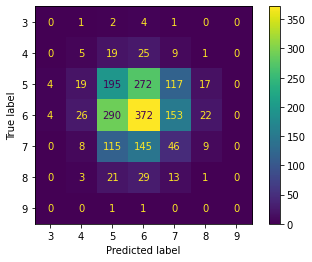

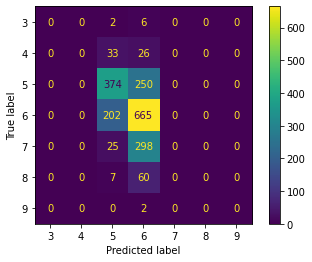

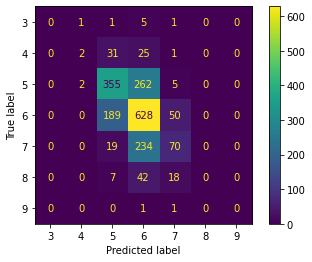

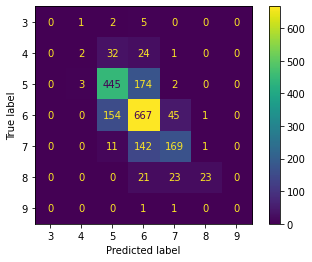

In [17]:
# plot confusion matrix, save in dict
# save all plots in .png; change the output directory!...
train_cms = {}
test_cms = {}
for key, model in models.items():
#     train_cms[key] = ConfusionMatrixDisplay.from_estimator(
#         model, X_train, y_train, values_format="d", display_labels=classes
#     )
#     name = '_'.join(key.lower().split())
#     plt.savefig(f'{name}_train_cm.png')
    
    test_cms = ConfusionMatrixDisplay.from_estimator(
        model, X_test, y_test, values_format="d", display_labels=classes
    )
    plt.savefig(f'{name}_test_cm.png')

In [10]:
# test scores table
test_scores = {}
for key, model in models.items():
    test_scores[key] = model.score(X_test, y_test)

In [11]:
# output table, change directory!..
test_scores = pd.Series(test_scores, name='test score')
out_table_1 = pd.DataFrame(results).append(test_scores).rename(
    index={"test_score": "cross_validation_score"}
).T
out_table_1.to_csv("test_scores.csv")
out_table_1

,fit_time,score_time,cross_validation_score,test score
Dummy,0.001 (+/- 0.000),0.001 (+/- 0.001),0.334 (+/- 0.010),0.317436
SVC,0.309 (+/- 0.009),0.107 (+/- 0.001),0.536 (+/- 0.010),0.532821
Linear Regression,0.212 (+/- 0.012),0.001 (+/- 0.000),0.543 (+/- 0.009),0.541026
Random Forest,0.412 (+/- 0.004),0.024 (+/- 0.001),0.624 (+/- 0.012),0.669744


In [12]:
lr_coefs = pd.DataFrame(
    lr.coef_.transpose(), index=X_train.columns.tolist(), columns=np.sort(y_train.unique()).tolist()
)
lr_coefs

,3,4,5,6,7,8,9
fixed acidity,0.651619,-0.403416,-0.582145,-0.490074,0.123705,0.052629,0.647683
volatile acidity,0.922409,0.769150,0.200172,-0.377274,-0.757045,-0.514800,-0.242612
citric acid,-0.184348,-0.032293,0.021435,-0.043433,-0.094738,0.026068,0.307309
residual sugar,-0.225348,-0.663651,-0.391711,-0.058676,0.668930,0.802430,-0.131974
chlorides,0.528545,0.127296,0.106748,0.085667,-0.178763,0.011603,-0.681097
free sulfur dioxide,0.343800,-0.926014,-0.238855,-0.000272,0.085486,0.356070,0.379786
total sulfur dioxide,0.218504,0.070574,0.276616,-0.136402,-0.173707,-0.290908,0.035322
density,-0.019254,0.704142,0.583253,0.454668,-0.525109,-0.539791,-0.657908
pH,0.250856,-0.268387,-0.416426,-0.334722,-0.002903,0.028116,0.743465
sulphates,-0.432473,0.048226,-0.096634,0.167124,0.483418,0.311746,-0.481407


In [13]:
top_3_feats = lr_coefs.mean(axis=1).sort_values(ascending=False).index.tolist()[:3]
top_3_feats

['fixed acidity', 'pH', 'type']

In [21]:
# Max coef feature for each class
results = {}
for c in classes:
    results[c] = [lr_coefs.index.tolist()[lr_coefs[c].argmax()]]

pd.DataFrame(results, index = ["Max coef feature for each class"])

,3,4,5,6,7,8,9
Max coef feature for each class,type,type,density,density,residual sugar,residual sugar,alcohol


In [33]:
lr_feats = copy.deepcopy(lr_coefs)
for c in classes:
    lr_feats[c] = lr_feats[c].sort_values(ascending = False).index.tolist()
    
lr_feats.reset_index().drop(columns=['index']) #.iloc[[0,1,2]]

,3,4,5,6,7,8,9
0,type,type,density,density,residual sugar,residual sugar,alcohol
1,volatile acidity,volatile acidity,total sulfur dioxide,sulphates,sulphates,alcohol,pH
2,fixed acidity,density,volatile acidity,chlorides,alcohol,free sulfur dioxide,fixed acidity
3,chlorides,chlorides,chlorides,alcohol,fixed acidity,sulphates,free sulfur dioxide
4,free sulfur dioxide,total sulfur dioxide,citric acid,free sulfur dioxide,free sulfur dioxide,fixed acidity,citric acid
5,pH,sulphates,sulphates,citric acid,pH,pH,type
6,total sulfur dioxide,citric acid,free sulfur dioxide,residual sugar,citric acid,citric acid,total sulfur dioxide
7,density,pH,residual sugar,total sulfur dioxide,total sulfur dioxide,chlorides,residual sugar
8,citric acid,fixed acidity,pH,pH,chlorides,total sulfur dioxide,volatile acidity
9,residual sugar,alcohol,fixed acidity,volatile acidity,density,type,sulphates


In [16]:
# sth for future use if needed
svc.classes_
lr.classes_
rf.classes_

# svc.predict_proba(X_test) 
lr.predict_proba(X_test)
rf.predict_proba(X_test)

svc.coef_  # shape is misleading
lr.coef_
# rf.coef_

array([[ 6.51618577e-01,  9.22409175e-01, -1.84347663e-01,
        -2.25347774e-01,  5.28545422e-01,  3.43799716e-01,
         2.18504448e-01, -1.92542077e-02,  2.50855804e-01,
        -4.32473357e-01, -6.67771091e-01,  1.12642819e+00],
       [-4.03416361e-01,  7.69149668e-01, -3.22933292e-02,
        -6.63651075e-01,  1.27295707e-01, -9.26014243e-01,
         7.05737009e-02,  7.04141537e-01, -2.68386974e-01,
         4.82264973e-02, -6.42829379e-01,  2.16175288e+00],
       [-5.82145429e-01,  2.00172056e-01,  2.14354065e-02,
        -3.91710923e-01,  1.06748211e-01, -2.38855378e-01,
         2.76615903e-01,  5.83253100e-01, -4.16425731e-01,
        -9.66344545e-02, -8.86393599e-01, -9.32350330e-01],
       [-4.90074220e-01, -3.77274169e-01, -4.34334715e-02,
        -5.86761259e-02,  8.56673128e-02, -2.71966486e-04,
        -1.36401761e-01,  4.54668290e-01, -3.34721501e-01,
         1.67124497e-01,  1.64969847e-02, -7.52746239e-01],
       [ 1.23705215e-01, -7.57044812e-01, -9.4737757